In [1]:
#import necessary lib
import pandas as pd 
import os
import cv2 as cv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

C:\Users\sayus\miniconda3\envs\te\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sayus\miniconda3\envs\te\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sayus\miniconda3\envs\te\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sayus\miniconda3\envs\te\lib\site-packages\tensorflow\python\framework

In [2]:
#load train and val attributes
x_train = []
x_val = []
train_attributes = pd.read_csv('./split_data/train_attributes.csv')
val_attributes = pd.read_csv('./split_data/val_attributes.csv')

In [3]:
#load images in  array
for index in train_attributes.index:
    img_name = train_attributes['filename'][index]
    img_ = cv.imread(os.path.join('./split_data/train', img_name + '.jpg'),1)
    x_train.append(img_)
for index in val_attributes.index:
    img_name = val_attributes['filename'][index]
    img_ = cv.imread(os.path.join('./split_data/val', img_name + '.jpg'), 1)
    x_val.append(img_)

In [4]:
x_train = np.array(x_train)
x_val = np.array(x_val)
#extract values from dataframe
y_train = train_attributes.drop('filename', axis = 1).values
y_val = val_attributes.drop('filename', axis = 1).values

In [5]:
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((748, 300, 225, 3), (748, 3), (100, 300, 225, 3), (100, 3))

In [7]:
#import image data generator to avoid overfitting
train_datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                validation_split=0.2
)

In [8]:
# preprocess input for InceptionV3 Model
x_train = tf.keras.applications.inception_v3.preprocess_input(x_train)
x_val = tf.keras.applications.inception_v3.preprocess_input(x_val)

In [9]:
#for each attribute convert to one hot encoding vector
y_categorical_neck = to_categorical(y_train[:, 0], num_classes = 7)
y_categorical_sleeve_length = to_categorical(y_train[:,1], num_classes = 4)
y_categorical_pattern = to_categorical(y_train[:,2], num_classes = 10)

# for validation
y_categorical_neck_val = to_categorical(y_val[:, 0], num_classes = 7)
y_categorical_sleeve_length_val = to_categorical(y_val[:,1], num_classes = 4)
y_categorical_pattern_val = to_categorical(y_val[:,2], num_classes = 10)

In [10]:
#concatenate one hot encoded vectors for each attribute sequentially
y_train_final = np.append(y_categorical_neck, y_categorical_sleeve_length, axis = 1)
y_val_final = np.append(y_categorical_neck_val, y_categorical_sleeve_length_val, axis = 1)

In [11]:
y_train_final = np.append(y_train_final, y_categorical_pattern, axis = 1)
y_val_final = np.append(y_val_final, y_categorical_pattern_val, axis = 1)

In [12]:
y_train_final.shape, y_val_final.shape

((748, 21), (100, 21))

In [13]:
#import library for model building and training
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D, Dropout
from matplotlib import pyplot as plt

In [14]:
#define callbacks for model implemenetation

#earlystopping callback
early_stopping = EarlyStopping(monitor = "val_loss", patience = 7, verbose = 1, mode = 'min')

#learning rate scheduler callback
def scheduler(epoch, lr):
    decay_rate = 0.1 
    decay_step = 10
    if epoch != 0 and epoch%decay_step == 0:
        return lr*decay_rate
    else:
        return lr
LRscheduler = LearningRateScheduler(scheduler, verbose = 1)

#model checkpoint callback
checkpoint_filepath='Best_Accuracy_Model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True,
    save_freq='epoch')

In [15]:
#load pretrrained inception model with imagenet weights
fine_tuning_model =tf.keras.applications.InceptionV3(
                    include_top = False,
                    weights = 'imagenet',
                    input_shape = (300,225,3),
                    pooling= None,
                    classes = 21)

# freeze all layers in the base model
fine_tuning_model.trainable = False

# # un-freeze the BatchNorm layers, BatchNorm needs to learn weights according
#to distribution of images of current dataset not imagenet
for layer in fine_tuning_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

#add custom classification layers
x = fine_tuning_model.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
#activation functionsu used is sigmoid as each value for nodes in last layer is 0 or 1(binary classification for each node)
prediction = Dense(21, activation ='sigmoid')(x)

model = Model(inputs = fine_tuning_model.input, outputs = prediction)

opt = tf.keras.optimizers.SGD(lr = 1e-4)
#use binary crossentropy loss
model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'Adam')

print(model.summary())

callbacks = [LRscheduler, model_checkpoint_callback, early_stopping]


#with data augmentation
history = model.fit_generator(train_datagen.flow(x_train, y_train_final, batch_size = 8), 
                              validation_data = (x_val, y_val_final), steps_per_epoch = len(x_train)/8,
                             epochs = 15, callbacks = callbacks)
#save the final model
model.save('Final_Model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 225, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 112, 32) 96          conv2d[0][0]                     
________________________________________________________________________________


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
94/93 [==============================] - 57s 608ms/step - loss: 0.7076 - acc: 0.8347 - val_loss: 0.3910 - val_acc: 0.8548

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
94/93 [==============================] - 17s 183ms/step - loss: 0.3926 - acc: 0.8536 - val_loss: 0.3539 - val_acc: 0.8800

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
94/93 [==============================] - 15s 159ms/step - loss: 0.3545 - acc: 0.8627 - val_loss: 0.3638 - val_acc: 0.8567

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
94/93 [==============================] - 15s 159ms/step - loss: 0.3311 - acc: 0.8680 - val_loss: 0.3269 - val_acc: 0.8743

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
94/93 [=========================

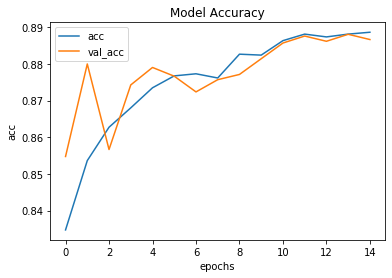

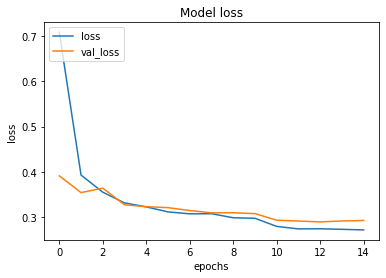

Max validation accuracy:  0.88809526
Max Training Accuracy:  0.88865554


In [16]:
#plot and see variation of loss and acc for model training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(('acc','val_acc'), loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(('loss','val_loss'), loc='upper left')
plt.show()

print("Max validation accuracy: ", max(history.history['val_acc']))
print("Max Training Accuracy: ", max(history.history['acc']))
